# Model Analisis dan prediksi Pengeluaran dengan LSTM

In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer

import os
from google.colab import userdata


## Load Data

In [27]:
# Kredensial dari Google Colab Secrets
kaggle_username = userdata.get('kaggle_username')  # Nama pengguna
kaggle_key = userdata.get('kaggle_key')     # Kunci API

# Set variabel lingkungan untuk Kaggle
os.environ['KAGGLE_USERNAME'] = kaggle_username
os.environ['KAGGLE_KEY'] = kaggle_key

In [28]:
!kaggle datasets download -d prasad22/daily-transactions-dataset
!unzip daily-transactions-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/prasad22/daily-transactions-dataset
License(s): other
daily-transactions-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  daily-transactions-dataset.zip
replace Daily Household Transactions.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Daily Household Transactions.csv  


In [29]:
df = pd.read_csv("Daily Household Transactions.csv")
df.head()

,Date,Mode,Category,Subcategory,Note,Amount,Income/Expense,Currency
0,20/09/2018 12:04:08,Cash,Transportation,Train,2 Place 5 to Place 0,30.0,Expense,INR
1,20/09/2018 12:03:15,Cash,Food,snacks,Idli medu Vada mix 2 plates,60.0,Expense,INR
2,19/09/2018,Saving Bank account 1,subscription,Netflix,1 month subscription,199.0,Expense,INR
3,17/09/2018 23:41:17,Saving Bank account 1,subscription,Mobile Service Provider,Data booster pack,19.0,Expense,INR
4,16/09/2018 17:15:08,Cash,Festivals,Ganesh Pujan,Ganesh idol,251.0,Expense,INR


## Preprocessing

In [30]:
# Konversi
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True, errors="coerce")
df = df.dropna(subset=["Date"])

# Filter hanya Expense dengan Currency INR
df = df[(df["Income/Expense"] == "Expense") & (df["Currency"] == "INR")]


In [31]:
# Total pengeluaran per hari
daily_expense = (
    df.groupby(df["Date"].dt.date)["Amount"]
    .sum()
    .reset_index()
    .rename(columns={"Date": "Date", "Amount": "Total_Expense"})
)
daily_expense["Date"] = pd.to_datetime(daily_expense["Date"])

## Feature Engineering

In [32]:
# Day of week (cyclical)
daily_expense["DayOfWeek"] = daily_expense["Date"].dt.dayofweek
daily_expense["DayOfWeek_sin"] = np.sin(2 * np.pi * daily_expense["DayOfWeek"] / 7)
daily_expense["DayOfWeek_cos"] = np.cos(2 * np.pi * daily_expense["DayOfWeek"] / 7)
daily_expense["Is_Weekend"] = daily_expense["DayOfWeek"].isin([5, 6]).astype(int)

In [33]:
# Moving average and trend features
daily_expense['MA7'] = daily_expense['Total_Expense'].rolling(window=7, min_periods=1).mean()
daily_expense['Diff'] = daily_expense['Total_Expense'].diff().fillna(0)
daily_expense['Perc_Change'] = daily_expense['Total_Expense'].pct_change().fillna(0)

daily_expense["Expense_to_MA7_Ratio"] = daily_expense["Total_Expense"] / daily_expense["MA7"]
mean_expense = daily_expense["Total_Expense"].mean()
daily_expense["Expense_to_Mean_Ratio"] = daily_expense["Total_Expense"] / mean_expense

In [34]:
# Perubahan mingguan
daily_expense["Week"] = daily_expense["Date"].dt.isocalendar().week
weekly_expense = (
    daily_expense.groupby("Week")["Total_Expense"].sum()
    .reset_index()
    .rename(columns={"Total_Expense": "Weekly_Total_Expense"})
)
weekly_expense["Prev_Week_Expense"] = weekly_expense["Weekly_Total_Expense"].shift(1)
weekly_expense["Weekly_Change_Ratio"] = (
    weekly_expense["Weekly_Total_Expense"] / weekly_expense["Prev_Week_Expense"]
).replace([np.inf, -np.inf], np.nan).fillna(1)

daily_expense = daily_expense.merge(
    weekly_expense[["Week", "Weekly_Change_Ratio"]],
    on="Week",
    how="left",
)

In [35]:
# Rasio pengeluaran harian dibandingkan hari sebelumnya
daily_expense["Prev_Day_Expense"] = daily_expense["Total_Expense"].shift(1).bfill()
daily_expense["Expense_to_Prev_Day_Ratio"] = (
    daily_expense["Total_Expense"] / daily_expense["Prev_Day_Expense"]
).replace([np.inf, -np.inf], np.nan).fillna(1)

In [36]:
# Fitur kumulatif pengeluaran bulanan (monthly cumulative expense ratio)

daily_expense["Month"] = daily_expense["Date"].dt.to_period("M")
monthly_expense = (
    daily_expense.groupby("Month")["Total_Expense"]
    .sum()
    .reset_index()
    .rename(columns={"Total_Expense": "Monthly_Total_Expense"})
)
monthly_mean = monthly_expense["Monthly_Total_Expense"].mean()

daily_expense = daily_expense.merge(monthly_expense, on="Month", how="left")
daily_expense["Expense_to_Monthly_Total_Ratio"] = (
    daily_expense["Total_Expense"] / daily_expense["Monthly_Total_Expense"]
)
daily_expense["Monthly_Total_to_Mean_Ratio"] = (
    daily_expense["Monthly_Total_Expense"] / monthly_mean
)

In [37]:
# 6. Imputasi NaN
daily_expense.bfill(inplace=True)
daily_expense.ffill(inplace=True)

In [38]:
# --- Log transform pengeluaran ---
daily_expense["Log_Expense"] = np.log1p(daily_expense["Total_Expense"])

# ------------------------------------------
# 3. Normalisasi fitur numerik
# ------------------------------------------
features_to_scale = [
    "Total_Expense",
    "Log_Expense",
    "MA7",
    "Diff",
    "Perc_Change",
    "Expense_to_MA7_Ratio",
    "Expense_to_Prev_Day_Ratio",
    "Expense_to_Mean_Ratio",
    "Weekly_Change_Ratio",
    "Expense_to_Monthly_Total_Ratio",
    "Monthly_Total_to_Mean_Ratio",
]

scaler = MinMaxScaler()
daily_expense[features_to_scale] = scaler.fit_transform(daily_expense[features_to_scale])

In [39]:
# Normalized_Expense
daily_expense["Normalized_Expense"] = daily_expense["Total_Expense"]

## Modelling

## XGBooster (Klasifikasi)

In [40]:
# Windowing untuk Prediksi 7 Hari

window_size = 14
forecast_horizon = 7

selected_features = [
    "Normalized_Expense",
    "MA7",
    "Diff",
    "Perc_Change",
    "Expense_to_MA7_Ratio",
    "Expense_to_Prev_Day_Ratio",
    "Expense_to_Mean_Ratio",
    "Weekly_Change_Ratio",
    "Expense_to_Monthly_Total_Ratio",
    "Monthly_Total_to_Mean_Ratio",
]

X = []
y_class = []

for i in range(len(daily_expense) - window_size - forecast_horizon):
    window = daily_expense[selected_features].iloc[i : i + window_size].values
    next_7_days = daily_expense["Normalized_Expense"].iloc[
        i + window_size : i + window_size + forecast_horizon
    ].values

    # Hitung rasio rata-rata pengeluaran 7 hari depan vs 14 hari window sebelumnya
    ratio = np.mean(next_7_days) / np.mean(window[:, selected_features.index("Normalized_Expense")])

    # Label kelas berdasarkan rasio
    if ratio > 1.1:
        label = "Boros"
    elif ratio < 0.9:
        label = "Hemat"
    else:
        label = "Balance"

    X.append(window)
    y_class.append(label)

X = np.array(X)
y_class = np.array(y_class)

In [41]:
# --- Fungsi ekstrak fitur statistik dari window ---
def extract_stat_features(X_windows):
    stats = []
    for w in X_windows:
        stat_features = []
        for col in range(w.shape[1]):
            stat_features.extend(
                [
                    np.mean(w[:, col]),
                    np.std(w[:, col]),
                    np.max(w[:, col]),
                    np.min(w[:, col]),
                ]
            )
        stats.append(stat_features)
    return np.array(stats)


X_stats = extract_stat_features(X)

# --- Fitur temporal ---
temporal_features = []
for i in range(window_size, len(daily_expense) - forecast_horizon):
    date = daily_expense["Date"].iloc[i]
    temporal_features.append([date.day, date.isocalendar()[1], date.month])
temporal_features = np.array(temporal_features)

# Pastikan jumlah sampel fitur temporal sama dengan X_stats dan X
assert temporal_features.shape[0] == X.shape[0], "Panjang fitur temporal tidak cocok"

In [42]:
# --- Flatten X window, gabungkan semua fitur ---
X_flat = X.reshape(X.shape[0], -1)
X_enhanced = np.hstack([X_flat, X_stats, temporal_features])

# --- Label encoding ---
le = LabelEncoder()
y_encoded = le.fit_transform(y_class)

X_train, X_test, y_train, y_test = train_test_split(
    X_enhanced, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [43]:
imp = SimpleImputer(strategy="mean")
X_train = imp.fit_transform(X_train)
X_test = imp.transform(X_test)

print(f"Jumlah NaN pada X_train setelah imputasi: {pd.DataFrame(X_train).isnull().sum().sum()}")

Jumlah NaN pada X_train setelah imputasi: 0


In [44]:
# ---Pipeline XGBoost dan Hyperparameter tuning---
smote = SMOTE(random_state=42)

xgb = XGBClassifier(
    objective="multi:softmax",
    num_class=3,
    eval_metric="mlogloss",
    use_label_encoder=False,
    random_state=42,
)

pipeline = ImbPipeline(
    steps=[
        ("smote", smote),
        ("xgb", xgb),
    ]
)

param_grid = {
    "xgb__max_depth": [3, 5, 7, 9],
    "xgb__learning_rate": [0.01, 0.05, 0.1],
    "xgb__n_estimators": [100, 200, 300],
    "xgb__gamma": [0, 0.1, 0.3, 0.5],
    "xgb__min_child_weight": [1, 3, 5],
    "xgb__subsample": [0.6, 0.8, 1.0],
    "xgb__colsample_bytree": [0.6, 0.8, 1.0],
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grid,
    n_iter=30,
    scoring="accuracy",
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42,
)

search.fit(X_train, y_train)

# Buat prediksi di data test
y_pred_smote = search.predict(X_test)

print("Best params:", search.best_params_)
print("Best CV score:", search.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:52:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best params: {'xgb__subsample': 1.0, 'xgb__n_estimators': 200, 'xgb__min_child_weight': 1, 'xgb__max_depth': 5, 'xgb__learning_rate': 0.05, 'xgb__gamma': 0.3, 'xgb__colsample_bytree': 1.0}
Best CV score: 0.8366057838660579


In [45]:
from sklearn.metrics import classification_report

print("Classification Report:\n")
print(classification_report(y_test, y_pred_smote, target_names=le.classes_))


Classification Report:

              precision    recall  f1-score   support

     Balance       0.60      0.43      0.50         7
       Boros       0.97      0.83      0.90        36
       Hemat       0.84      0.96      0.89        48

    accuracy                           0.87        91
   macro avg       0.80      0.74      0.76        91
weighted avg       0.87      0.87      0.86        91



In [46]:
from sklearn.metrics import accuracy_score

print("Akurasi:", accuracy_score(y_test, y_pred_smote))


Akurasi: 0.8681318681318682


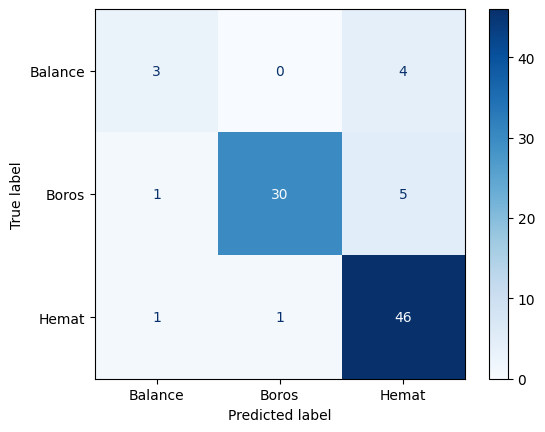

In [47]:
# Evaluasi: Confusion Matrix

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_smote, labels=le.transform(le.classes_))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [48]:
import joblib

# Simpan pipeline klasifikasi (sudah termasuk SMOTE dan XGBoost)
joblib.dump(search.best_estimator_, 'model_klasifikasi_xgb.pkl')

# Simpan LabelEncoder
joblib.dump(le, 'label_encoder.pkl')

['label_encoder.pkl']

#XGBoost (Prediksi)

In [49]:
import numpy as np
import pandas as pd
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import datetime

In [50]:
window_size = 14
forecast_horizon = 7
selected_features = [
    "Normalized_Expense",
    "MA7",
    "Diff",
    "Perc_Change",
    "Expense_to_MA7_Ratio",
    "Expense_to_Prev_Day_Ratio",
    "Expense_to_Mean_Ratio",
    "Weekly_Change_Ratio",
    "Expense_to_Monthly_Total_Ratio",
    "Monthly_Total_to_Mean_Ratio",
]

# --- Windowing untuk input X dan multi-output target y ---
X = []
y = []

for i in range(len(daily_expense) - window_size - forecast_horizon):
    window = daily_expense[selected_features].iloc[i : i + window_size].values
    next_7_days = daily_expense["Normalized_Expense"].iloc[
        i + window_size : i + window_size + forecast_horizon
    ].values
    X.append(window)
    y.append(next_7_days)

X = np.array(X)  # shape (samples, window_size, features)
y = np.array(y)  # shape (samples, forecast_horizon)


In [51]:
# Flatten fitur time window untuk model (RF butuh 2D input)
n_samples, n_timesteps, n_features = X.shape
X_reshaped = X.reshape(n_samples, n_timesteps * n_features)

# Split data train-test
X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y, test_size=0.2, random_state=42
)

# Buat model multioutput regresi dengan RandomForest
base_model = RandomForestRegressor(n_estimators=100, random_state=42)
model = MultiOutputRegressor(base_model)
model.fit(X_train, y_train)

MultiOutputRegressor(estimator=RandomForestRegressor(random_state=42))

In [52]:
# Prediksi di data test
y_pred = model.predict(X_test)

# Evaluasi model per hari prediksi
print("📊 Evaluasi Model (per hari):")
for i in range(forecast_horizon):
    mae = mean_absolute_error(y_test[:, i], y_pred[:, i])
    rmse = np.sqrt(mean_squared_error(y_test[:, i], y_pred[:, i]))  # dihitung di dalam loop
    r2 = r2_score(y_test[:, i], y_pred[:, i])
    print(f"Hari ke-{i+1}: MAE={mae:.4f}, RMSE={rmse:.4f}, R2={r2:.4f}")


📊 Evaluasi Model (per hari):
Hari ke-1: MAE=0.0442, RMSE=0.1131, R2=0.0173
Hari ke-2: MAE=0.0519, RMSE=0.1108, R2=-0.9062
Hari ke-3: MAE=0.0480, RMSE=0.1135, R2=0.0345
Hari ke-4: MAE=0.0370, RMSE=0.0716, R2=-0.6928
Hari ke-5: MAE=0.0430, RMSE=0.1221, R2=0.0517
Hari ke-6: MAE=0.0435, RMSE=0.0983, R2=-0.1619
Hari ke-7: MAE=0.0365, RMSE=0.0704, R2=-0.2790


In [53]:
# ==== Fungsi prediksi dan notifikasi ====

def predict_and_notify(last_window, mean_expense, std_expense):
    """
    last_window: array shape (window_size, features), input data terakhir dari user
    mean_expense, std_expense: untuk de-normalisasi hasil prediksi
    """
    x_input = last_window.reshape(1, window_size * n_features)
    pred_norm = model.predict(x_input).flatten()  # shape (7,)
    # De-normalisasi prediksi (kembalikan ke nominal)
    pred_nominal = pred_norm * std_expense + mean_expense

    # Hitung persentase perubahan dari rata-rata window terakhir
    avg_window_nominal = (last_window[:, selected_features.index("Normalized_Expense")] * std_expense + mean_expense).mean()
    notif = []
    for i, val in enumerate(pred_nominal):
        pct_change = ((val - avg_window_nominal) / avg_window_nominal) * 100
        status = "naik" if pct_change > 0 else "turun" if pct_change < 0 else "tetap"
        notif.append(
            f"{(datetime.date.today() + datetime.timedelta(days=i+1)).strftime('%A, %d %B %Y')}: "
            f"Rp{val:,.0f} ({status} {abs(pct_change):.1f}%)"
        )
    return notif


In [54]:
# ==== Contoh penggunaan fungsi ====
last_window_data = daily_expense[selected_features].iloc[-window_size:].values

mean_expense = 0.028155154287826802  # mean dari data original
std_expense = 0.08931599618280038    # std dev dari data original

# Denormalisasi hasil prediksi
denorm_pred = y_pred[0] * std_expense + mean_expense

import datetime

hari_ini = datetime.date.today()
prev = mean_expense * std_expense + mean_expense  # asumsi hari ke-0 = rata-rata historis

print("📅 Prediksi Pengeluaran Nominal dan Persentase Perubahan:")

# Simpan semua nominal untuk kalkulasi mingguan
weekly_nominals = []

for i in range(forecast_horizon):
    tanggal = hari_ini + datetime.timedelta(days=i+1)
    nominal = denorm_pred[i]
    nominal_rp = int(nominal * 1_000_000)  # konversi ke rupiah

    # Hitung perubahan persen dari hari sebelumnya
    change_pct = ((nominal - prev) / prev) * 100 if prev != 0 else 0
    arah = "naik" if change_pct >= 0 else "turun"

    print(f"{tanggal.strftime('%A, %d %B %Y')}: Rp{nominal_rp:,} ({arah} {abs(change_pct):.1f}%)")

    prev = nominal
    weekly_nominals.append(nominal)

# Hitung total dan persentase kenaikan selama 7 hari
total_awal = weekly_nominals[0]
total_akhir = weekly_nominals[-1]
kenaikan_total = total_akhir - total_awal
kenaikan_persen = (kenaikan_total / total_awal) * 100 if total_awal != 0 else 0

print("\n📈 Total Perubahan Mingguan:")
print(f"Total kenaikan nominal: Rp{int(kenaikan_total * 1_000_000):,}")
print(f"Persentase kenaikan: {kenaikan_persen:.2f}%")


📅 Prediksi Pengeluaran Nominal dan Persentase Perubahan:
Monday, 02 June 2025: Rp33,075 (naik 7.8%)
Tuesday, 03 June 2025: Rp29,496 (turun 10.8%)
Wednesday, 04 June 2025: Rp28,849 (turun 2.2%)
Thursday, 05 June 2025: Rp30,354 (naik 5.2%)
Friday, 06 June 2025: Rp29,491 (turun 2.8%)
Saturday, 07 June 2025: Rp29,488 (turun 0.0%)
Sunday, 08 June 2025: Rp30,029 (naik 1.8%)

📈 Total Perubahan Mingguan:
Total kenaikan nominal: Rp-3,046
Persentase kenaikan: -9.21%


In [55]:
# Hitung rata-rata pengeluaran 14 hari terakhir (sebagai pembanding)
mean_last_14_days = np.mean(daily_expense["Normalized_Expense"].iloc[-window_size:])

# Hitung rata-rata prediksi 7 hari ke depan
mean_next_7_days = np.mean(y_pred[0])  # Ambil baris pertama (prediksi paling baru)

# Hitung rasio
ratio = mean_next_7_days / mean_last_14_days

# Klasifikasi
if ratio > 1.1:
    status = "🔴 Boros"
elif ratio < 0.9:
    status = "🟢 Hemat"
else:
    status = "🟡 Balance"

# Tampilkan notifikasi
print("\n📢 Notifikasi Kategori Perilaku Pengeluaran:")
print(f"Prediksi minggu depan tergolong: **{status}**")
print(f"(Rata-rata pengeluaran diprediksi {'naik' if ratio > 1 else 'turun'} sebesar {abs((ratio - 1) * 100):.1f}%) dibanding 14 hari sebelumnya)")



📢 Notifikasi Kategori Perilaku Pengeluaran:
Prediksi minggu depan tergolong: **🔴 Boros**
(Rata-rata pengeluaran diprediksi naik sebesar 95.2%) dibanding 14 hari sebelumnya)


In [56]:
# prediksi
joblib.dump(model, 'model_prediksi_regresi.pkl')


['model_prediksi_regresi.pkl']

In [57]:
# Simpan StandardScaler, Imputer, objek penting lainnya
joblib.dump(imp, 'imputer.pkl')
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

In [58]:
import zipfile
import os

files_to_zip = [
    'model_klasifikasi_xgb.pkl',
    'model_prediksi_regresi.pkl',
    'label_encoder.pkl',
    'scaler.pkl'
    'imputer.pkl',  # kalau kamu simpan imputernya
    'requirements.txt'
]

# --- 2. Nama file zip yang ingin dibuat ---
zip_filename = 'model_harian.zip'

# --- 3. Buat file zip ---
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for file in files_to_zip:
        if os.path.exists(file):
            zipf.write(file)
        else:
            print(f"⚠️ File tidak ditemukan dan tidak dimasukkan ke zip: {file}")

# --- 4. Download zip ke komputer lokal ---
from google.colab import files
files.download(zip_filename)


⚠️ File tidak ditemukan dan tidak dimasukkan ke zip: scaler.pklimputer.pkl
⚠️ File tidak ditemukan dan tidak dimasukkan ke zip: requirements.txt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>